In [ ]:
import json
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.prompts import PromptTemplate
import os
import pandas as pd
from datetime import datetime, timedelta

from dotenv import load_dotenv
load_dotenv()

# --- GRAPH STATE ---
class GraphState(dict):
    mode: str
    job_title: str
    must_have: list
    nice_to_have: list
    responsibilities: list
    location: str
    experience: str
    job_description: str
    resume_text: str
    extra_criteria: list
    evaluation: str


# --- UTILITIES ---
def save_criteria(must_have, nice_to_have, file_path="criteria.json"):
    with open(file_path, "w") as f:
        json.dump({"must_have": must_have, "nice_to_have": nice_to_have}, f, indent=2)
    print(f"\n✅ Criteria saved to {file_path}")


def save_job_description(jd_text, file_path="job_description.txt"):
    with open(file_path, "w") as f:
        f.write(jd_text)
    print(f"✅ Job Description saved to {file_path}")


def load_criteria(file_path="criteria.json"):
    with open(file_path, "r") as f:
        data = json.load(f)
    return data["must_have"], data["nice_to_have"]


# --- MENU STEP ---
def choose_mode_node(state: GraphState):
    print("\n=== Master Resume Agent ===")
    print("1. Create Job Description & Criteria")
    print("2. Shortlist Candidate Resume")
    print("3. Schedule Interview")
    choice = input("Enter choice (1/2/3): ").strip()
    return {"mode": "jd" if choice == "1" else "shortlist" if choice == "2" else "interview"}



# --- JOB DESCRIPTION FLOW ---
def create_jd_node(state: GraphState):
    job_title = input("\nEnter Job Title: ").strip()
    responsibilities = []
    must_have = []
    nice_to_have = []

    print("\nEnter Job Responsibilities (type 'done' to finish):")
    while True:
        c = input("Responsibility: ").strip()
        if c.lower() == "done":
            break
        responsibilities.append(c)

    print("\nEnter Must-Have Criteria (type 'done' to finish):")
    while True:
        c = input("Must-Have: ").strip()
        if c.lower() == "done":
            break
        must_have.append(c)

    print("\nEnter Nice-to-Have Criteria (type 'done' to finish):")
    while True:
        c = input("Nice-to-Have: ").strip()
        if c.lower() == "done":
            break
        nice_to_have.append(c)

    location = input("\nEnter Job Location (optional, press Enter to skip): ").strip()
    experience = input("Enter Experience Requirement (e.g., 3-5 years, optional): ").strip()

    # Save criteria for shortlisting
    save_criteria(must_have, nice_to_have)

    return {
        "job_title": job_title,
        "responsibilities": responsibilities,
        "must_have": must_have,
        "nice_to_have": nice_to_have,
        "location": location,
        "experience": experience
    }


def generate_jd_node(state: GraphState):
    """Generate professional JD text using GPT."""
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)
    prompt = PromptTemplate(
        input_variables=["title", "responsibilities", "must_have", "nice_to_have", "location", "experience"],
        template="""
Write a professional job description for the following role.

Job Title: {title}
Location: {location}
Experience Required: {experience}

Responsibilities:
{responsibilities}

Must-Have Skills:
{must_have}

Nice-to-Have Skills:
{nice_to_have}

Format it clearly with sections:
- Job Title
- Location
- Experience Required
- Responsibilities
- Must-Have Skills
- Nice-to-Have Skills
"""
    )
    chain = prompt | llm
    jd_text = chain.invoke({
        "title": state["job_title"],
        "responsibilities": "\n".join(state["responsibilities"]) if state["responsibilities"] else "Not specified",
        "must_have": "\n".join(state["must_have"]) if state["must_have"] else "Not specified",
        "nice_to_have": "\n".join(state["nice_to_have"]) if state["nice_to_have"] else "Not specified",
        "location": state["location"] if state["location"] else "Not specified",
        "experience": state["experience"] if state["experience"] else "Not specified"
    }).content

    save_job_description(jd_text)
    return {"job_description": jd_text}


# --- SHORTLIST FLOW ---
def load_resume_node(state: GraphState):
    loader = PyPDFLoader("docs/sample.pdf")
    pages = loader.load()
    resume_text = "\n".join([p.page_content for p in pages])

    must_have, nice_to_have = load_criteria()
    return {
        "resume_text": resume_text,
        "must_have": must_have,
        "nice_to_have": nice_to_have,
        "extra_criteria": []
    }


def evaluate_resume_node(state: GraphState):
    all_criteria = state["must_have"] + state["nice_to_have"] + state["extra_criteria"]

    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    prompt = PromptTemplate(
        input_variables=["resume_text", "must_have", "nice_to_have", "extra"],
        template="""
You are a hiring assistant.

Must-Have Criteria:
{must_have}

Nice-to-Have Criteria:
{nice_to_have}

Extra Criteria from Recruiter:
{extra}

Rules:
- Candidate must meet ALL must-have criteria to be shortlisted.
- Nice-to-have and extra criteria improve chances but are not mandatory.

Resume:
{resume_text}

Return:
Decision: <SHORTLIST or REJECT>
Reason:
- ...
- ...
"""
    )
    chain = prompt | llm
    evaluation = chain.invoke({
        "resume_text": state["resume_text"],
        "must_have": "\n".join(state["must_have"]),
        "nice_to_have": "\n".join(state["nice_to_have"]),
        "extra": "\n".join(state["extra_criteria"]) if state["extra_criteria"] else "None"
    }).content
    return {"evaluation": evaluation}


def human_check_node(state: GraphState):
    print("\n=== Resume Evaluation Result ===")
    print(state["evaluation"])
    choice = input("\nDo you want to add extra criteria? (yes/no): ").strip().lower()
    if choice == "yes":
        new_c = input("Enter extra criteria: ").strip()
        updated_extra = state["extra_criteria"] + [new_c]
        return {"extra_criteria": updated_extra}
    else:
        return END

def human_feedback_jd_node(state: GraphState):
    print("\n=== Generated Job Description ===")
    print(state["job_description"])

    choice = input("\nDoes this JD look good? (yes/no): ").strip().lower()
    if choice == "yes":
        print("✅ Final JD confirmed.")
        return END
    else:
        feedback = input("Enter your feedback to improve the JD: ").strip()

        llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)
        prompt = PromptTemplate(
            input_variables=["jd", "feedback"],
            template="""
You are a hiring assistant. 
Here is the current job description:

{jd}

The recruiter provided the following feedback:
{feedback}

Revise the job description accordingly while keeping it professional and well-structured.
Return only the improved job description.
"""
        )
        chain = prompt | llm
        new_jd = chain.invoke({"jd": state["job_description"], "feedback": feedback}).content

        save_job_description(new_jd)
        return {"job_description": new_jd}
    
def normalize_time_with_llm(raw_time: str) -> str:
    
    """Use LLM to parse and return interview time in HH:MM 24h format."""
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    prompt = PromptTemplate(
        input_variables=["raw_time"],
        template="""
You are a helpful assistant. Convert the following human-provided interview time into
24-hour HH:MM format (e.g., 12:00, 15:00, 18:00).  

Rules:
- Only output the normalized time (nothing else).
- Valid range is 12:00 to 18:00.  
- If input is outside this range, return "INVALID".

Input: {raw_time}
Output:
"""
    )
    chain = prompt | llm
    return chain.invoke({"raw_time": raw_time}).content.strip()



def suggest_alternative_with_llm(requested_time, available_slots):
    """LLM suggests best alternative slot from available ones."""
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    prompt = PromptTemplate(
        input_variables=["requested_time", "slots"],
        template="""
A recruiter requested an interview at {requested_time}, but that slot is unavailable.
Here are the available slots: {slots}

Suggest the single best alternative (closest to requested time). 
Return ONLY the time in HH:MM format (24h).
"""
    )
    chain = prompt | llm
    return chain.invoke({
        "requested_time": requested_time,
        "slots": ", ".join(available_slots)
    }).content.strip()


def interview_scheduler_node(state: GraphState):
    while True:
        df = load_interview_schedule()

        print("\n=== Interview Scheduler ===")
        print("Current Schedule:")
        if df.empty:
            print("No interviews scheduled yet.")
        else:
            print(df)

        candidate = input("\nEnter candidate name to schedule (or type 'exit' to stop): ").strip()
        if candidate.lower() == "exit":
            print("✅ Exiting interview scheduler.")
            return END

        raw_time = input("Enter preferred interview time (any format, e.g., '3pm', '3:00 pm', '15:00'): ").strip()
        preferred_time = normalize_time_with_llm(raw_time)

        if preferred_time == "INVALID":
            print("❌ Invalid time. Interviews can only be scheduled between 12pm and 6pm.")
            continue

        # Check booked slots
        booked_times = df["interview_time"].tolist()
        if preferred_time in booked_times:
            print(f"⚠️ Slot at {preferred_time} is already taken.")

            # Find alternative slots
            start = datetime.strptime("12:00", "%H:%M")
            end = datetime.strptime("18:00", "%H:%M")
            available_slots = []
            while start <= end:
                slot = start.strftime("%H:%M")
                if slot not in booked_times:
                    available_slots.append(slot)
                start += timedelta(hours=1)

            if available_slots:
                # Let LLM suggest best alternative
                suggested = suggest_alternative_with_llm(preferred_time, available_slots)
                print(f"👉 Suggested alternative slot: {suggested}")
                choice = input(f"Do you want to schedule {candidate} at {suggested}? (yes/no): ").strip().lower()
                if choice == "yes":
                    df = pd.concat([df, pd.DataFrame([[candidate, suggested]], 
                                                     columns=["candidate_name", "interview_time"])],
                                   ignore_index=True)
                    save_interview_schedule(df)
                    print(f"✅ Scheduled {candidate} at {suggested}.")
                    return END
                else:
                    print("❌ Not scheduled. Let's try again.")
                    continue
            else:
                print("❌ No slots available today.")
                return END
        else:
            # Schedule normally
            df = pd.concat([df, pd.DataFrame([[candidate, preferred_time]], 
                                             columns=["candidate_name", "interview_time"])],
                           ignore_index=True)
            save_interview_schedule(df)
            print(f"✅ Scheduled {candidate} at {preferred_time}.")
            return END


INTERVIEW_FILE="job_interview.csv"
def load_interview_schedule():
    try:
        df = pd.read_csv(INTERVIEW_FILE)
    except FileNotFoundError:
        df = pd.DataFrame(columns=["candidate_name", "interview_time"])
    return df

def save_interview_schedule(df):
    df.to_csv(INTERVIEW_FILE, index=False)
    print("✅ Interview schedule updated.")



# --- BUILD MASTER GRAPH ---
workflow = StateGraph(GraphState)

# Menu
workflow.add_node("choose_mode", choose_mode_node)

# JD Flow
workflow.add_node("create_jd", create_jd_node)
workflow.add_node("generate_jd", generate_jd_node)

# Shortlist Flow
workflow.add_node("load_resume", load_resume_node)
workflow.add_node("evaluate_resume", evaluate_resume_node)
workflow.add_node("human_check", human_check_node)

# Entry
workflow.set_entry_point("choose_mode")

workflow.add_conditional_edges(
    "choose_mode",
    lambda state: state["mode"],
    {
        "jd": "create_jd",
        "shortlist": "load_resume",
        "interview": "interview_scheduler"
    }
)

# Add node
workflow.add_node("human_feedback_jd", human_feedback_jd_node)

# JD flow connections
workflow.add_edge("create_jd", "generate_jd")
workflow.add_edge("generate_jd", "human_feedback_jd")
workflow.add_edge("human_feedback_jd", "human_feedback_jd")  # loop until confirmed

# Shortlisting chain
workflow.add_edge("load_resume", "evaluate_resume")
workflow.add_edge("evaluate_resume", "human_check")
workflow.add_edge("human_check", "evaluate_resume")  # loop if extra checks
workflow.add_node("interview_scheduler", interview_scheduler_node)





In [36]:
graph = workflow.compile()

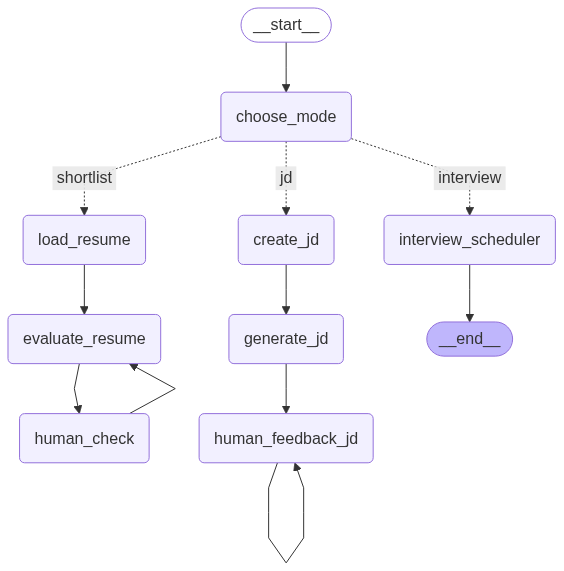

In [37]:
from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [39]:


# --- RUN ---
graph.invoke({})


=== Master Resume Agent ===
1. Create Job Description & Criteria
2. Shortlist Candidate Resume
3. Schedule Interview

=== Interview Scheduler ===
Current Schedule:
  candidate_name interview_time
0       Kritagya          13:00
1           Alok          15:00
❌ Invalid time. Interviews can only be scheduled between 12pm and 6pm.

=== Interview Scheduler ===
Current Schedule:
  candidate_name interview_time
0       Kritagya          13:00
1           Alok          15:00
⚠️ Slot at 15:00 is already taken.
👉 Suggested alternative slot: 16:00
✅ Interview schedule updated.
✅ Scheduled how about 3pm at 16:00.


InvalidUpdateError: Expected dict, got __end__
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_GRAPH_NODE_RETURN_VALUE

In [10]:
graph.invoke({})


=== Master Resume Agent ===
1. Create Job Description & Criteria
2. Shortlist Candidate Resume

=== Resume Evaluation Result ===
Decision: SHORTLIST  
Reason:  
- Meets all must-have criteria: Proficient in Python, SQL, and has experience with Langchain.  
- Strong educational background in Mathematics and Computing, which supports statistical knowledge.  
- Relevant work experience in data science and machine learning, demonstrating the ability to apply skills in practical scenarios.  
- Additional skills in data science tools and technologies enhance the candidate's profile.

=== Resume Evaluation Result ===
Decision: REJECT  
Reason:  
- Does not meet the minimum work experience requirement of 3 years; has only 2 years of experience.  
- While the candidate has experience in Python and SQL, they do not explicitly mention proficiency in statistics, which is a must-have criterion.  
- Although the candidate has experience with Langchain, they do not meet all the must-have criteria fo

InvalidUpdateError: Expected dict, got __end__
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_GRAPH_NODE_RETURN_VALUE